# Phase Gradient Averages
The aim of this notebook is to identify the distribution of Phase Gradient Averages (PGAs) across a large sample.
The PGA is a simple measurement of the average value of the Phase Gradient ($D_k$) for a sample. The average value serves as a diagnostic tool to determine the fairness of that sample, as the average value of $D_k$ is expected to be approximately zero. If the value of the PGA is significantly deviant from zero, it is fair to assume that the sample is not a realistic sample of the Universe.

This notebook aims to split a single dataset into multiple subsets and analyse the PGAs of each subset, eventually producing a distribution of PGA values over the whole set. We expect that the direction of the phase gradient will have no effect on the distribution itself, but this will be investigated further.

# Data Import
Import the dataset to be analysed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spy
import os
cwd = os.getcwd() #Fetch the current working directory for the GitHub repository
data = np.loadtxt('{0}\GiggleZ Redshift Data\z0pt000.dat'.format(cwd)) #Load data file
x_data, y_data, z_data = data[:,1], data[:,2], data[:,3] #Assign x, y and z data values from columns 1, 2 and 3 from the data file
resolution = 512 #Dictates the number of bins in x,y,z (Use powers of 2)
field_length = 1000 #The length of x,y,z in Mpc/h
nx,ny,nz = resolution,resolution,resolution #number of bins in x, y and z. Stick to powers of 2!
lx,ly,lz = field_length,field_length,field_length #needs units (Mpc/h)! #length of each dimension
dx,dy,dz = lx/nx,ly/ny,lz/nz #length of each bin
datagrid = np.zeros((nx,ny,nz)) #initialize the data grid
datagrid, edges = np.histogramdd(np.vstack([x_data,y_data,z_data]).transpose(),bins=(nx,ny,nz),range=((0.,lx),(0.,ly),(0.,lz))) #bin data
kx = 2.*np.pi*np.fft.fftfreq(nx,d=lx/nx) 
ky = 2.*np.pi*np.fft.fftfreq(ny,d=ly/ny)
kz = 2.*np.pi*np.fft.fftfreq(nz,d=lz/nz)
k_tot = np.sqrt(kx[:,np.newaxis,np.newaxis]**2 + ky[np.newaxis,:,np.newaxis]**2 + kz[np.newaxis,np.newaxis,:]**2)

mean_density = np.float(len(x_data))/np.float(nx*ny*nz)
overdensities = datagrid/mean_density-1 +0j

In [11]:
L_array = np.linspace(0,field_length,resolution) #Array for values of length
GRFgrid=np.zeros((resolution, resolution, resolution),dtype=complex) #Initial state of 3D grid (zeros)
sig = np.std(overdensities)
for i in range(0,resolution): #For loop to create a 3D grid
    for j in range(0,resolution):
        for k in range(0,resolution):
            GRFgrid[i,j,k] = np.random.normal(scale=sig) #Assigns each pixel a GRF value (standardised to GiggleZ statistics)
FFTgrid = np.fft.fftn(GRFgrid) #Perform a Fourier Transform on the density field
GRFamplitudes = np.sqrt(FFTgrid.real**2 + FFTgrid.imag**2)
GRFphases = np.arctan2(FFTgrid.imag, FFTgrid.real)

# Cuts
Cut the sample into subsets

In [37]:
subsets = 16 #The number of subsets to divide the sample into (for each dimension) - stick to powers of 2!
pps = int(resolution/subsets) #Number of pixels per subset
subset = np.zeros((pps,pps,pps), dtype=np.ndarray) #Initialize the subset array
for i in range(subsets):
    print('Creating Subsets... ({0}%)'.format(100*i/subsets))
    for j in range(subsets):
        for k in range(subsets):
            subset[i,j,k] = overdensities[i*pps:(i+1)*pps,j*pps:(j+1)*pps,k*pps:(k+1)*pps]
print('Creating Subsets... (100%)')

Creating Subsets... (0.0%)
Creating Subsets... (6.25%)
Creating Subsets... (12.5%)
Creating Subsets... (18.75%)
Creating Subsets... (25.0%)
Creating Subsets... (31.25%)
Creating Subsets... (37.5%)
Creating Subsets... (43.75%)
Creating Subsets... (50.0%)
Creating Subsets... (56.25%)
Creating Subsets... (62.5%)
Creating Subsets... (68.75%)
Creating Subsets... (75.0%)
Creating Subsets... (81.25%)
Creating Subsets... (87.5%)
Creating Subsets... (93.75%)
Creating Subsets... (100%)


# Subset Analysis

In [38]:
mean_vals = np.zeros((subsets,subsets,subsets))
for i in range(subsets):
    print('Analysing Subsets... {0}%'.format(100*i/subsets))
    for j in range(subsets):
        for k in range(subsets):
            FFTfield = np.fft.fftn(subset[i,j,k]) #Perform a Fourier Transform on the density field
            #Samplitudes = np.sqrt(FFTfield.real**2 + FFTfield.imag**2)
            Sphases = np.arctan2(FFTfield.imag, FFTfield.real)
            SD_k = np.roll(Sphases,1,axis=0)-Sphases
            for a in range(pps):
                for b in range(pps):
                    for c in range(pps):
                        if SD_k[i,j,k] < -np.pi:
                            SD_k[i,j,k] += 2*np.pi
                        if SD_k[i,j,k] > np.pi:
                            SD_k[i,j,k] -= 2*np.pi
            Sdist = SD_k[SD_k != 0].flatten()
            mean_vals[i,j,k] = np.var(Sdist)
print('Analysing Subsets... (100%)')

Analysing Subsets... 0.0%
Analysing Subsets... 6.25%
Analysing Subsets... 12.5%
Analysing Subsets... 18.75%
Analysing Subsets... 25.0%
Analysing Subsets... 31.25%
Analysing Subsets... 37.5%
Analysing Subsets... 43.75%
Analysing Subsets... 50.0%
Analysing Subsets... 56.25%
Analysing Subsets... 62.5%
Analysing Subsets... 68.75%
Analysing Subsets... 75.0%
Analysing Subsets... 81.25%
Analysing Subsets... 87.5%
Analysing Subsets... 93.75%
Analysing Subsets... (100%)


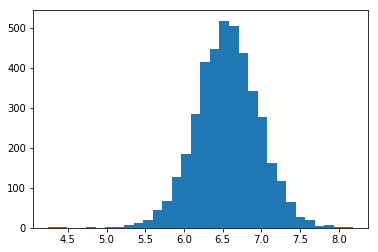

In [39]:
plt.figure('mean_vals_hist')
plt.hist(mean_vals.flatten(),bins=subsets*2)
plt.show()

In [43]:
print((-np.pi-np.pi)**2/12)

3.289868133696453


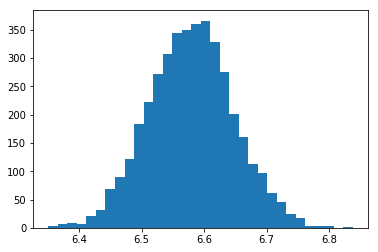

In [36]:
plt.figure('mean_vals_hist')
plt.hist(mean_vals.flatten(),bins=subsets*2)
plt.show()